In [1]:
import numpy as np
import matplotlib.pyplot as plt

Often the ***marginal likelihood*** is intractable, thus we cannot specify a posterior distribution. Thus, we usually need to *approximate* the posterior distribution. This is typically done in one of two ways:
1. Simulation - generate data and use its empirical distribution to approximate the posterior
2. Distributional approximation - approximate directly with simple parametric distributions (like Gaussian)
    - Approximating the posterior density with some tractable density $q(\theta)$ is called ***Variational Inference***

## 4.1 Simulation Methods

Recall our building-blocks:
$$
\begin{align*}
& \text{Prior Distribution: } \ \ \ \ \ \ \ \ p(\theta) \\
& \text{Sampling Distribution: } \ p(y|\theta) \\
& \text{Marginal Likelihood: } \ \ \ \ \ p(y) \\
& \text{Posterior Distribution: } \ \ p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \rightarrow p(\theta|y) \propto p(\theta)p(y|\theta)
\end{align*}
$$

Now, how can we sample $\theta_1, ..., \theta_s$ from a posterior distribution $p(\theta|y)$ when that distribution is *unknown*? (As is the case whenever $p(y)$ is unknown or the posterior is not a conjugate.\
The solution is to sample from the numerator or a function $q(\theta ; y)$ proportional to it. I.e. we simulate the posterior by generating random samples from the unnormalized posterior distribution:
$$q(\theta ; y) \propto p(\theta|y) \propto p(\theta)p(y|\theta)$$

## 4.1.1 Grid Approximation

This is a straightforwd brute-force-y approach also known as *direct dicrete approximation*. 
1. Split up the distribution into an even-spaced grid bounded by limits $a$ and $b$ with increment sizes $i$, yielded grid buckets: $$g_1 = a+ i/2, ..., \ g_m = b - i/2$$
2. Evaluate the probability of the unnormalized posterior density within each grid bucket and *normalize* them to obtain estimated values of the posterior distribution within each grid bucket:
$$\hat p_1 \coloneqq \frac{q(g_1; y)}{\sum_{i=1}^m q(g_i; y)}, \ ..., \ \hat p_m \coloneqq \frac{q(g_m; y)}{\sum_{i=1}^m q(g_i ; y)}$$
3. Generate S samples from the grid distribution:
    - Generate $\lambda_s$ from a categorical distribution (e.. multinomial) with outcomes $g_1, ..., g_m$ and probabilities $\hat p_1, ..., \hat p_m$
    - Add uniform noise to each $\lambda_s$ such that the generated values may fall outside of the grid buckets, i.e.: $$\lambda_s = \lambda_s + \epsilon, \ \ \epsilon \sim U(-i/2, i/2)$$

## 4.2 Monte Carlo Integration

In general, computing integrals by simulation is known as "Monte Carlo Integration", be it by grid approximation or otherwise.

### 4.2.1 Strong Law of Large Numbers (SLL)

For $n$ IID RVs $Y_1,.Y_2,..., Y_n$, the sample mean of the RVs will converge to the expected value of their sum with *probability* equal to 1 as $n$ approaches infinity (so long as the expected value is finite). I.e.:
$$P\bigg(\lim_{n\rightarrow \infty} \frac{1}{n} \sum_{i=1}^n Y_i = \mu \bigg) = 1$$

### 4.2.3 Example of Monte Carlo Integration

Because the simulated values $\lambda_1, ..., \lambda_S$ are IID samples of the posterior distribution, which has a finite expected value, by the strong law of large numbers the sample mean of the simulated values converges in probability to the true expected value of the posterior distribution:
$$\frac{1}{S}\sum_{i=1}^S \lambda_i \rightarrow E[\Lambda | Y=y]$$

## 4.3 Monte Carlo Markov Chain (MCMC) Methods

The grid approximation gets unwieldly as the dimensionality of the parameter being estimated increases (e.g. for multivariate distributions). This is because the size of the grid scales exponentially with dimension.

Enter MCMC which is based on iteratively sampling from a ***Markov Chain*** with a stationary distribution that is the target distribution; i.e., the posterior distribution $p(\theta|y)$

### 4.3.1 Markov Chain

A *discrete time* Markov Chain is a sequence of random variables $X_1,X_2,...$ which has a ***Markov Property***:
$$P(X_{i+1} = x_{i+1} | X_i = x_i, ..., X_0 = x_0) = P(X_{i+1}=x_{i+1} | X_i = x_i)$$
Explicitly, the probability of $p(x_{i+1})$ is *only dependent on* the last observation $x_i$, not on any of the prior observations.\
The state of the next observation is only ever dependent upon the state of the current observation.

The ***State Space*** $\mathcal{S}$ of the Markov Chain is the set of all possible values for the random variables $X_i$

### 4.3.2 MCMC Sampling

The ***Stationary Distribution*** is a distribution $\pi(x)$ with the following property:\
If you start the chain from the stationary distribution such that $P(X_0=k)=\pi(k), \ \forall k\in \mathcal{S}$, then all other $P(X_i = k)=\pi(k)$ for all $i = 1, 2,...$

The stationary distribution is a distribution for which the probabilities at each state are *independent* of the probabilities at any other state.\
If we consider each $X_i$ to be an observed state in $\mathcal S$, the stationary distribution is simply the asymptotic, long-run, distribution of observed states. when we define the stationary distribution to be the posterior distribution, we may approximate the posterior by generating a large number of sample observations from the Markov Chain.

Moreover, Markov Chains (with few exceptions) have the property that they will converge *in behavior* to the stationary distribution over time as well:
$$\lim_{n\rightarrow \infty} P(X_{i+1} = x_{i+1} | X_i = x_i) \rightarrow \pi(x_{i+1}), \ \ \forall i\in\{1,...,n\}$$
The intuition for this is that the distribution of current states (from which $x_i$ is drawn) becomes stationary as the chain length increases, so we end up with a stationary distribution of future states.

Because of this convergence, the initial observations drawn from an MCMC model are usually discarded because they are poor representatives of the stationary posterior distribution that we hope to approximate. Often the first **half** of all samples are discarded. They are reffered to as the ***warm-up period***

It can be difficult to determine whether the MCMC model has reached convergence. A common approach is to run multiple models in parrallel and compare their results.

## 4.3.3 Example MCM: Gibbs Sampler

The Gibbs sampler updates components of the parameter vector one-at-a-time, generating a value from the conditional posterior distribution for each $\theta_j$ given all other $\theta_{i\ne j}$: $$p(\theta_j| \mathbf{\theta}_{i\ne j}, \bf y)$$

Consider a bivariate normal distribution a parameter of interest $\mathbf \mu = [\mu_1, \mu_2]$ and covariance matrix: $$\mathbf \Sigma_0 = \begin{bmatrix} 1 \ \ \ \ \rho \\ \rho \ \ \ \ 1 \end{bmatrix}$$

Assuming that $\rho = -0.7$ and an improper uniform prior $p(\mu) \propto 1$, the posterior will be bivariate normal with $N(\mu, \mathbf \Sigma_0)$

The conditional distributions fo each $\mu_i$ are then:
$$
\mu_1|\mu_2, Y \sim N(y_1 + \rho(\mu_2 - y_2), 1 - \rho^2) \\
\mu_2|\mu_1, Y \sim N(y_2 + \rho(\mu_1 - y_1), 1 - \rho^2)
$$

This lends itself immediately to a Markov chain:

In [14]:
y = np.array([0, 0])
rho = -0.7

mu1, mu2 = [2], [2]

# Gibbs sampling
for i in range(1, 1000):
    mu1.append(np.random.normal(y[0] + rho * (mu2[i-1] - y[1]), np.sqrt(1 - rho**2)))
    mu2.append(np.random.normal(y[1] + rho * (mu1[i] - y[0]), np.sqrt(1 - rho**2)))

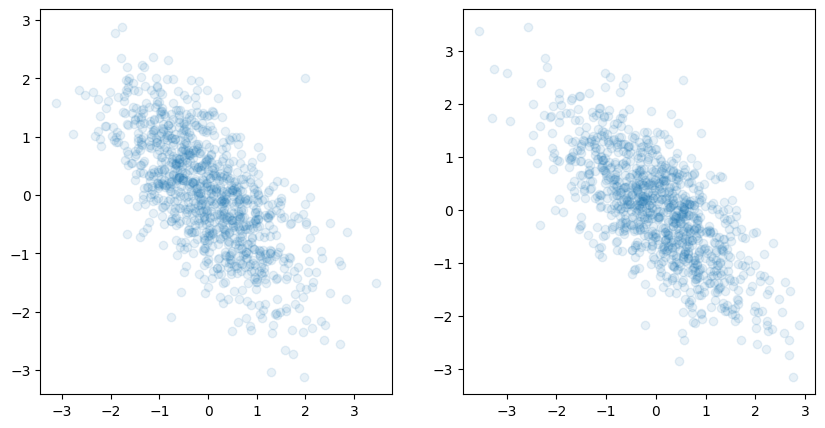

In [18]:
# draw Gibbs samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(mu1, mu2, 'o', alpha=0.1)

# plot bivariate normal samples for comparison
sigma = np.array([[1, rho], [rho, 1]])
bvn_samples = np.random.multivariate_normal(mean=[0, 0], cov=sigma, size=1000)
axs[1].plot(bvn_samples[:, 0], bvn_samples[:, 1], 'o', alpha=0.1)
plt.show()
